# Day 4: Lesion Analysis to Identify Functional Units in a Neural Network

Neural networks can be extremely powerful in solving problems computationally but due to their mathematical complexity they have often been deemed a black box into which we are simply inputting something, the network somehow analyzes it and arrives at a conclusion.

However, it has been different to really understand **how a network decomposes a task**.

In the following tutorial we will approach this problem by **lesioning some components** in the network to see how these lesions affect network performance.

Lesioning neural networks is relatively similar to lesioning real brains though much easier and comes with less ethical complications. Instead of hoping for a lesioned patient or performing tDCS or TMS on a healthy patient, we can simply change some numeric values in the network weights.

- Lesioning becomes particularly useful when we have a network that has to solve **multiple tasks** at once as it allows us to see **whether segregated streams**, like those in the brain, are advantageous to processing.

- Multi-task network offer the exciting possibility to **reinstate more similar conditions to the one that the visual system in the brain faced**. Rather than evolving very task-specific networks one at a time, the brain had to **evolve into a network solving multiple tasks** at the same time. The idea is that if we see similarly **segregated streams** in a neural network compared to the brain, that could mean that this task decomposition is an optimized solution to the tasks our brain is facing.

In this tutorial, you will learn:

*   how to **lesion a kernel** in a neural network
*   how to analyze **task division** in a dual-task network
*   how to **visualize task-specific kernel** input preferences


Before jumping into the main tutorial we will quickly import all the libraries we need as well as the datasets and pretrained model weights.

As a last note: During the tutorial you will see ellipses (...) pop up in the code. These mean that you need to fill in some code yourself.

In [1]:
# These are some basic data science libraries that allow us to investigate our datasets and plot some graphs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import os
import shutil

# These are all the libraries that will allow us to do Deep Learning
import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from torchvision.datasets import ImageFolder

# TQDM is a useful library that implements progress bars for for-loops
from tqdm.notebook import tqdm

# These are some file-management libraries we will need in the beginning
import os
import shutil
import zipfile

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Great, all libraries are imported now.

Now let's get our dataset and the pretrained model. You can do that by linking the following Google Drive folder to your own Drive using a shortcut. Then you can link your drive to Google Colab and you are good to go.

Here is the link to the shared folder:

[Click me](https://drive.google.com/drive/folders/1yFNw65xd79dxlgnyrdxI5U2BwyjRVh7h?usp=sharing)

In [5]:
from google.colab import drive
drive.mount('/content/drive')

source_folder = '/content/drive/MyDrive/UvA/202406_sumSchool_neuroAI/3_tutorials/SummerSchoolTutorials'
destination_folder = '/content/SummerSchoolTutorials'

if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# Copy files from Google Drive to the local directory
for item in os.listdir(source_folder):
    source_path = os.path.join(source_folder, item)
    destination_path = os.path.join(destination_folder, item)
    if os.path.isfile(source_path):
        shutil.copy(source_path, destination_path)

# Unzip the zip files into the local directory
for item in os.listdir(destination_folder):
    if item.endswith('.zip'):
        zip_path = os.path.join(destination_folder, item)
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(destination_folder)
        os.remove(zip_path)  # Remove the zip file after extracting

# Remove __MACOSX directories if they exist
for root, dirs, files in os.walk(destination_folder):
    if '__MACOSX' in dirs:
        shutil.rmtree(os.path.join(root, '__MACOSX'))

# List the files in the local directory to confirm
os.listdir(destination_folder)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


['Datasets',
 'Hold Out',
 'Weights',
 'selections_record_dual_obj.npz',
 'selections_record_dual_face.npz']

## Network Investigation and Kernel Visualization

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Alright, now we have all the files and libraries we need. For this tutorial we will be using a network that has been trained on two tasks (object and face recognition). The network architecture is VGG16, which is the same architecture that was used in the studies that were presented today. While there are multiple ways to train a multi-task network, the simplest one arguably is just to concatenate the datasets and extend the output channels of the last layer of the classifier to include to combined number of classes. This means that the tasks in our network are divided by the input images, rather than each image being applicable to all tasks and using either a multi-label setup or a multi-task head setup.

First let's print the model to have an overview of what we are working with.

In [7]:
dual_vgg = torchvision.models.vgg16(pretrained = False)

print(dual_vgg)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

As you can see, the model has an encoder with 13 convolutional layers and a decoder/classifier with 3 fully-connected layers. We can also see that the final classifier layer still has 1000 output channels. This is because the included models in PyTorch are specialized for the ImageNet-1k dataset which as the name suggests has 1000 classes. Thus, we need to change the output channels of the last layer to properly load our weights.
The dual task network we will be using is the exact same network that was used in the studies by Katharina Dobs. However, instead of working with the entire dataset, we will be working only with a very small subset today to save some time.

In [8]:
checkpoint = torch.load('/content/SummerSchoolTutorials/Weights/epoch_50.pth.tar', map_location = 'cpu')

# Extract the state_dict for the model
state_dict = checkpoint['state_dict']

dual_vgg_weights = {}
for k, v in state_dict.items():
    if k.startswith('module.'):
        dual_vgg_weights[k[7:]] = v
    else:
        dual_vgg_weights[k] = v

num_classes = 2137

num_features = dual_vgg.classifier[6].in_features
dual_vgg.classifier[6] = nn.Linear(num_features, num_classes)

dual_vgg.load_state_dict(dual_vgg_weights)

<All keys matched successfully>

Great, now the model is ready to go!

One of the easiest ways to investigate the features a neural network extracts is to simply pass an image into it and record the activation maps. The following code creates a function that does so and overlays the activation map from a kernel of your choice over the original image.

You can choose an input image of your choice and insert the path into the function. Ideally, choose one image of a face and one image of an object.

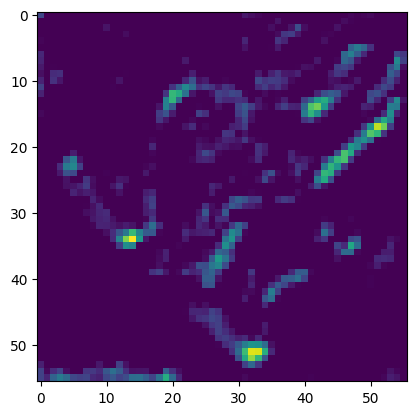

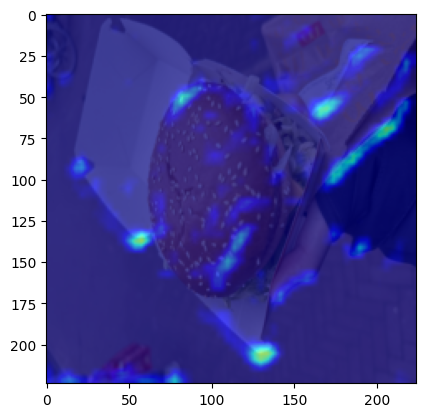

In [11]:
def visualize_image_activations(image_path, network, layer_index, kernel_index):
    # Preprocess the image
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
    ])
    img_t = transform(Image.open(image_path)).unsqueeze(0)

    # Register hook to extract feature maps
    def extract_maps(_, __, output):
        global feature_maps
        feature_maps = output

    hook = network.features[layer_index].register_forward_hook(extract_maps)

    # Forward pass through the network
    with torch.no_grad():
        _ = network.features(img_t)
    hook.remove()

    # Process and visualize the feature map
    feature_maps_s = feature_maps.squeeze(0)

    plt.imshow(feature_maps_s[kernel_index].numpy(), cmap = 'viridis')

    plt.show()

    feature_maps_n = (feature_maps_s - feature_maps_s.min()) / (feature_maps_s.max() - feature_maps_s.min())

    feature_maps_u = feature_maps_n.unsqueeze(0)
    feature_maps_r = torch.nn.functional.interpolate(feature_maps_u, size=(224, 224), mode='bilinear', align_corners=False)
    feature_maps_s2 = feature_maps_r.squeeze(0)

    feature_map_num = feature_maps_s2[kernel_index].detach().numpy()
    feature_map_colored = plt.cm.jet(feature_map_num)[:, :, :3]

    input_image_np = img_t.squeeze(0).permute(1, 2, 0).numpy()
    input_image_np = (input_image_np - input_image_np.min()) / (input_image_np.max() - input_image_np.min())

    overlay = input_image_np * 0.3 + feature_map_colored * 0.7  # Blend the images

    plt.imshow(overlay)

    plt.show()

visualize_image_activations(image_path = 'IMG_2756.jpg', network = dual_vgg, layer_index = 15, kernel_index = 20)

**ToDo (1)**:

Run this to compare a couple activation maps from different layers to get an approximate idea of the models processing steps. If you are struggling, you can reveal some code below by clicking "Show code". Remember, you still need to input the path to your image

In [ ]:
# Write your code here

...

...

...

In [ ]:
# @title

image = '/path/to/your/image.jpg'

print('Layer 0')
visualize_image_activations(image_path = image, network = dual_vgg, layer_index = 0, kernel_index = 20)
print('')

print('Layer 10')
visualize_image_activations(image_path = image, network = dual_vgg, layer_index = 10, kernel_index = 20)
print('')

print('Layer 19')
visualize_image_activations(image_path = image, network = dual_vgg, layer_index = 19, kernel_index = 20)
print('')

print('Layer 28')
visualize_image_activations(image_path = image, network = dual_vgg, layer_index = 28, kernel_index = 20)

You quickly notice that this method is quite ineffective in identifying how to network is structured and dividied across task. This is where the lesions come in.

**ToThink (1)**:

What property of the neural network allows the deeper neurons to be sensitive to more complex patterns? What is the analogue of that property in the visual system in the brain? You can write your answer below

*Write your answer here*

## Lesioning Kernels

Kernels in a neural network are essentially weight matrices that are used for convolving over an input matrix. We can access and visualize these kernels by indexing into the network. The purpose of a lesion is to disable a part of a network so that its feature extractions are not able to be used by later layers. In the brain, this can be done through several ways, some more invasive than other but they usually either significantly lower the frequency of firing (decreasing the information transmitted) of the neuron/kernel or  make it completely inactive (removing any transmitted information). This process is much easier in neural networks and can be particularly useful in identifying how that part of the network influences its behavior.

Let's take the network we have just investigated and look at a kernel of our choice. We will also save original weights as we want to avoid having to reload the weights every time after lesioning. To have a good comparison we will visualize the results of that method as well.

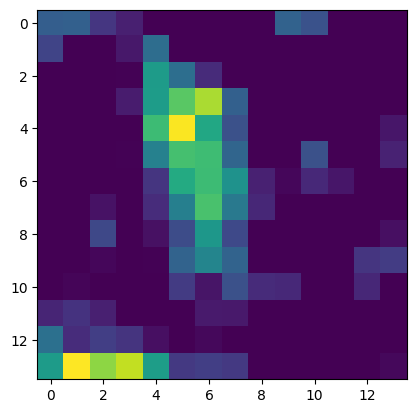

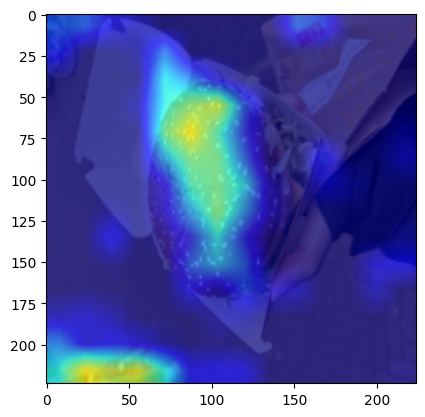

In [14]:
layer = 24
kernel = 20

image = 'IMG_2756.jpg'

orig_weights = dual_vgg.features[layer].weight.data[kernel].clone()
orig_bias = dual_vgg.features[layer].bias.data[kernel].clone()

visualize_image_activations(image_path = image, network = dual_vgg, layer_index = layer, kernel_index = kernel)

In [17]:
orig_weights.size()     # [channel x kernel size x kernal size]

torch.Size([512, 3, 3])

Now that we know how that kernel looks without a lesion, let us do the lesion to confirm that the kernel has been ablated

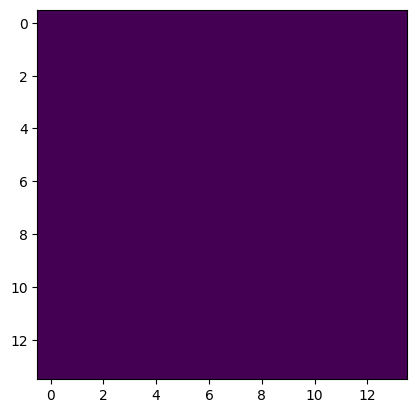

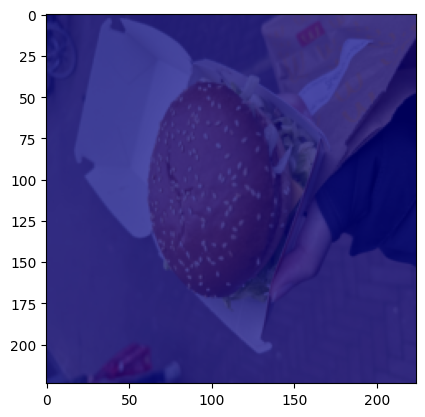

In [18]:
dual_vgg.features[layer].weight.data[kernel] = 0.0
dual_vgg.features[layer].bias.data[kernel] = 0.0

visualize_image_activations(image_path = image, network = dual_vgg, layer_index = layer, kernel_index = kernel)

As you can see, while the feature map showed activation before the lesion, there now is no activation remaining afterwards. This means that the lesion was successful. But what is the impact of that lesion considering that the next layer after this one is now missing a sensible feature map to convolve over, which will likely have some effects on overall network behavior.

In [19]:
# Before going to the next section, let's reset the kernel quickly

dual_vgg.features[layer].weight.data[kernel] = orig_weights
dual_vgg.features[layer].bias.data[kernel] = orig_bias

## Relating Lesions to Network Behavior

To investigate how a lesion affects the network behavior we can simply **compare the loss before the lesion with after the lesion** similarly to how we would compare human behavior before a temporary lesion with after the lesion. This measure will give us an estimate of **how important this particular feature map** is to the task that the loss was computed on.

- [feature map <> activation <> output <> input for the next layer]

Let's start by preparing the dataset:

To properly do the analysis we need to create a filter for the entire dataset so that we can selectively have batches with images from only one task. Because our dataset is already very small (20 instances per class) we will not be doing a train/val split for this analysis.

In [20]:
dataset_path = '/content/SummerSchoolTutorials/Datasets/DualDataset'

transform = transforms.Compose([ transforms.Resize((256, 256)),
                                 transforms.CenterCrop(224),
                                 transforms.ToTensor(),
                                 transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

# Load the dataset
dataset = ImageFolder(root=dataset_path, transform=transform)

# Custom dataset to filter by prefix: 'face' if face class, 'object' if object class
class FilteredDataset(Dataset):
    def __init__(self, dataset, prefix):
        self.dataset = dataset
        self.indices = [i for i, (path, _) in enumerate(dataset.samples) if os.path.basename(os.path.dirname(path)).startswith(prefix)]

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        original_idx = self.indices[idx]
        return self.dataset[original_idx]

# Create datasets for faces and objects
face_dataset = FilteredDataset(dataset, 'face')
object_dataset = FilteredDataset(dataset, 'object')

# Create data loaders
face_dataloader = DataLoader(face_dataset, batch_size=32, shuffle=True)
object_dataloader = DataLoader(object_dataset, batch_size=32, shuffle=True)


Now that the dataloaders are ready, we can continue by probing how the lesion of a single kernel affects the network behavior. To do so we will first establish a baseline measure.

In [21]:
dual_vgg = dual_vgg.to(device)

dual_vgg.eval()

criterion = nn.CrossEntropyLoss()

# Get base values
pbar1 = tqdm(enumerate(face_dataloader), desc = 'Establishing Face Loss Baseline', total = len(face_dataloader))
pbar2 = tqdm(enumerate(object_dataloader), desc = 'Establishing Object Loss Baseline', total = len(object_dataloader))

with torch.no_grad():

    batch_losses = np.zeros(len(face_dataloader), dtype = float)

    correct = 0
    total = 0

    for idx, batch in pbar1:

        image, label = batch

        image, label = image.to(device), label.to(device)

        output = dual_vgg(image)

        loss = criterion(output, label)

        predicted = torch.argmax(output, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()

        batch_losses[idx] = loss.item()

    base_face_loss = np.mean(batch_losses)
    base_face_loss_sd = np.std(batch_losses)

    print(f'Face Loss: {base_face_loss}, Face Loss SD {base_face_loss_sd}')

with torch.no_grad():

    batch_losses = np.zeros(len(object_dataloader), dtype = float)

    correct = 0
    total = 0

    for idx, batch in pbar2:

        image, label = batch

        image, label = image.to(device), label.to(device)

        output = dual_vgg(image)

        loss = criterion(output, label)

        predicted = torch.argmax(output, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()

        batch_losses[idx] = loss.item()

    base_object_loss = np.mean(batch_losses)
    base_object_loss_sd = np.std(batch_losses)

    print(f'Object Loss: {base_object_loss}, Object Loss SD {base_object_loss_sd}')

Establishing Face Loss Baseline:   0%|          | 0/1072 [00:00<?, ?it/s]

Establishing Object Loss Baseline:   0%|          | 0/265 [00:00<?, ?it/s]

KeyboardInterrupt: 

If this takes too long, you can also load the following cell that can be revealed by clicking "Show code". It contains the loss values and standard deviations from my own runs.

In [22]:
# @title
base_face_loss = 1.4565794246632662
base_face_loss_sd = 0.4835781355369047

base_object_loss = 2.281959489156615
base_object_loss_sd = 0.45413462432476875

Great, now that we have some values to compare to, lets lesion a kernel and repeat this analysis. To help with the process, I have defined a function below:

In [ ]:
def test_lesion_effect(task, dataloader, network, layer_idx, kernel_idx, batches = 100):

    network = network.to(device)

    pbar = tqdm(enumerate(dataloader), desc=f'Establishing {task} Loss Effect for Kernel {kernel_idx}', total=batches)

    # Save original kernel weights

    orig_weights = network.features[layer_idx].weight.data[kernel_idx].clone()
    if network.features[layer_idx].bias is not None:
        orig_bias = network.features[layer_idx].bias.data[kernel_idx].clone()
    else:
        orig_bias = None

    # Lesion kernel

    network.features[layer_idx].weight.data[kernel_idx] = 0.0
    if network.features[layer_idx].bias is not None:
        network.features[layer_idx].bias.data[kernel_idx] = 0.0

    network.eval()

    # Measure Effect on Loss

    with torch.no_grad():

        running_loss = 0.0

        for idx, batch in pbar:

            if idx >= batches:
                break

            image, label = batch

            image, label = image.to(device), label.to(device)

            output = network(image)

            loss = criterion(output, label)

            running_loss += loss.item()

            pbar.set_postfix({'loss': running_loss / (idx + 1)})

        lesion_loss = running_loss/batches

        network.features[layer_idx].weight.data[kernel_idx] = orig_weights
        if orig_bias is not None:
            network.features[layer_idx].bias.data[kernel_idx] = orig_bias

    return lesion_loss

Okay, now we know what the absolute change in loss is for each task when lesioning a single kernel, but this is not super informative yet. Because they are different tasks, the losses may operate on different scales especially as the network may not learn both tasks equally well. To fix this, we must establish a relative measure within tasks to identify which kernels are important for each task.

**ToDo (2)**:

Iterate through some of the kernels in a deeper layer and save the results to a list containing the kernel index and the associated effect on the loss. An entire layer of 512 kernels would take quite long even on GPU, so we will only do a smaller version of this process by running the analysis for only 8 kernels instead so that you have seen it running once. When writing your code, make sure to print the difference between the lesion loss and the original loss of the task. This will help you see better how a lesion affects each task. Then, visualize the entire results using a bar graph with one bar for each task-kernel combination.

In [ ]:
# Write your code here

...

...

...

...

You can reveal the correct code below by clicking "Show code".

In [ ]:
# @title
dual_vgg.to(device)

criterion = nn.CrossEntropyLoss()

ranking = np.zeros((8, 2), dtype = float)

for kidx in range(8):
    raw_effect_face = test_lesion_effect('Face', face_dataloader,  dual_vgg, 28, kidx, batches = 50)

    face_effect = raw_effect_face - base_face_loss

    raw_effect_object = test_lesion_effect('Object', object_dataloader, dual_vgg, 28, kidx, batches = 50)

    object_effect = raw_effect_object - base_object_loss

    print(f'Kernel {kidx}: Effect on Face Loss: {face_effect}')
    print(f'Kernel {kidx}: Effect on Object Loss: {object_effect}')

    ranking[kidx, 0] = face_effect
    ranking[kidx, 1] = object_effect

fig, ax = plt.subplots(figsize=(10, 6))

index = np.arange(8)
bar_width = 0.35

# Plotting bars for face and object effects
face_bars = ax.bar(index, ranking[:, 0], bar_width, label='Face Effect')
object_bars = ax.bar(index + bar_width, ranking[:, 1], bar_width, label='Object Effect')

ax.set_xlabel('Kernel')
ax.set_ylabel('Effect')
ax.set_title('Face and Object Effects on Task Loss')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(index)
ax.legend()

plt.show()

You can also directly load the results for the first 8 kernels in the layer by loading the cell below:

In [ ]:
# @title
ranking = np.array([[-0.24118632, -0.15766363],
                    [-0.1633949,   0.05389339],
                    [ 0.06806312,  0.09304704],
                    [ 0.02567353, -0.10276617],
                    [-0.16002726, -0.03638811],
                    [ 0.04657509, -0.03296645],
                    [-0.07809152,  0.07486088],
                    [-0.03144749, -0.01088203]])

fig, ax = plt.subplots(figsize=(10, 6))

index = np.arange(8)
bar_width = 0.35

# Plotting bars for face and object effects
face_bars = ax.bar(index, ranking[:, 0], bar_width, label='Face Effect')
object_bars = ax.bar(index + bar_width, ranking[:, 1], bar_width, label='Object Effect')

ax.set_xlabel('Kernel')
ax.set_ylabel('Effect')
ax.set_title('Face and Object Effect on Task Loss')
ax.set_xticks(index + bar_width / 2)
ax.set_xticklabels(index)
ax.legend()

plt.show()

While you can see that there are some kernels that seem to similarly contribute to both tasks, quite a few seem to show high preference for one task, increasing that task's loss by much more than the other task's loss (sometimes even improving performance for the other task by lowering loss).

**ToThink (2)**:

Which lesion effects are we measuring with this method and which are we missing out on? Describe a method that can overcome this limitation:

*Write your answer here*

### Visualizing and Optimizing Task-Specific Kernels

Now that we have a list of kernels and their associated loss values for each task, we can create a ranking to identify the most important kernels for either task. Because the previous ranking was only on a subset of kernels and we do not want you to have to wait multiple hours, we will provide you with a full ranking of the previous task. Using this ranking, we can identify the most useful kernels for each task. In order to understand their functioning, we will use Gradient Ascent on a randomized input to maximize the mean activation of the feature maps resulting from the kernel. This means that in each iteration the algorithm slightly changes the input image in order to maximize the activation leading to the visualization of the preferred input of a kernel.

**ToDo (3)**:

Use the full ranking to find one object-preferring kernel and one face-preferring kernel and visualize their preferred input images using Gradient Ascent on a randomized input. Part of the code is already prepared so your task is to fill in the blanks.

In [ ]:
obj_array = np.load('/content/SummerSchoolTutorials/selections_record_dual_obj.npz', allow_pickle=True)
object_ranking = obj_array['selected_units']

print(f'Top10 Object Kernels: {object_ranking[:10]}')

face_array = np.load('/content/SummerSchoolTutorials/selections_record_dual_face.npz', allow_pickle=True)
face_ranking = face_array['selected_units']

print(f'Top10 Face Kernels: {face_ranking[:10]}')

Great, now we know the top face kernels and the top object kernels. Let's find out what features they are sensitive to by doing Gradient Ascent.

In [ ]:
# After finding the top-ranked kernels, continue here

def optimize_input(network, layer_idx, kernel_idx):

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  input_image = torch.randn(1, 3, 224, 224, requires_grad=True, device=device)

  network = network.to(device)

  optimizer = torch.optim.Adam([input_image], lr = 0.1)

  layer = network[layer_idx]

  def extract_activation(module, input, output):

      global activation

      activation = output[:, kernel_idx, :, :].clone()

  hook = layer.register_forward_hook(extract_activation)

  iterations = 250

  pbar = tqdm(range(iterations), desc = 'Image Optimization', total = iterations)

  for i in pbar:

    ...

    ...

    loss = ...

    ...

    ...

    pbar.set_postfix({'Loss': loss.item()})


  def rescale(img):
    img = img - img.min()
    img = img / img.max()

    return img

  img = input_image.detach().cpu().numpy()[0]
  img = np.transpose(rescale(img), (1, 2, 0))
  plt.imshow(img)
  plt.show()

  hook.remove()

You can find the full function code below by clicking "Show code".

In [ ]:
# @title
def optimize_input(network, layer_idx, kernel_idx):

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

  input_image = torch.randn(1, 3, 224, 224, requires_grad=True, device=device)

  network = network.to(device)

  optimizer = torch.optim.Adam([input_image], lr = 0.1)

  layer = network.features[layer_idx]

  def extract_activation(module, input, output):

      global activation

      activation = output[:, kernel_idx, :, :].clone()

  hook = layer.register_forward_hook(extract_activation)

  iterations = 250

  pbar = tqdm(range(iterations), desc = 'Image Optimization', total = iterations)

  for i in pbar:

    optimizer.zero_grad()

    network(input_image)

    loss = - activation.mean()

    loss.backward()

    optimizer.step()

    pbar.set_postfix({'Loss': loss.item()})


  def rescale(img):
    img = img - img.min()
    img = img / img.max()

    return img

  img = input_image.detach().cpu().numpy()[0]
  img = np.transpose(rescale(img), (1, 2, 0))
  plt.imshow(img)
  plt.show()

  hook.remove()

Run the completed function here:

In [ ]:
layer = ...
kernel = ...

optimize_input(dual_vgg, layer, kernel)

## Large-Scale Lesions and Task Segregation

Great, we now know which kernels are useful for either task and have a rough idea of what they are responsive to. The next step is to develop a measure that characterizes how divided a layer is between tasks. Are there many kernels that contribute similarly to both tasks or are there many specialized kernels?

To do this, we are gonna use the ranking of the Top50 kernels in the last convolutional layer for both tasks that Katharina Dobs has provided us for this tutorial, and do a larger-scale lesion of task-specific kernels to see how they affect our network behavior. Then we pass the data set through and measure how these large scale lesions affect the loss values of the two tasks. To evaluate the changes in loss following the lesions, we will use normalized values.

We will use these kernels for our larger lesion. The next step is to do the lesion and determine the normalized loss change. Remember that we already computed the baseline losses and standard deviations before when we did the single kernel lesions. We can use these values now in the computation of normalized loss changes. Usually, we would have to do this again as you should use a different dataset for this part of the evaluation but for simplicity and storage reasons, we will use this dataset again.

In [ ]:
print(f'Mean of Object Loss: {base_object_loss}')
print(f'Mean of Face Loss: {base_face_loss}')

print(f'Spread of Object Loss: {base_object_loss_sd}')
print(f'Spread of Face Loss: {base_face_loss_sd}')

Alright, we now have all the measures required for calculating normalized loss changes. The following is a function that computes the entire normalized loss changes for all combinations of lesions and task evaluations. This is a long code of block, so take a few moments to look at the function and what it does.

In [ ]:
def largelesiontest(network, face_set, object_set, face_ranking, object_ranking, lesion_extent = 0.2, num_batches = 200):

  base_mean_face_loss = 1.4565794246632662
  base_spread_face_loss = 0.4835781355369047

  base_mean_object_loss = 2.281959489156615
  base_spread_object_loss = 0.45413462432476875

  num_kernels = 512

  # First we determine how many kernels we need to lesion

  lesioned_kernel_num = int(lesion_extent * num_kernels)

  lesioned_face_kernels = face_ranking[:lesioned_kernel_num]
  lesioned_object_kernels = object_ranking[:lesioned_kernel_num]

  # We need to save the original weights so that we can reinstate them for later use

  orig_weights = network.features[28].weight.data.clone()
  orig_biases  = network.features[28].bias.data.clone()

  # Now we can lesion the kernels and record the loss for both tasks

  for idx in lesioned_face_kernels:
    network.features[28].weight.data[idx] = 0.0
    network.features[28].bias.data[idx] = 0.0

  pbar1 = tqdm(enumerate(face_dataloader), desc = f'Working on Face Dataloader for Face Lesion', total = num_batches)
  pbar2 = tqdm(enumerate(object_dataloader), desc = f'Working on Object Dataloader for Face Lesion', total = num_batches)

  network.eval()

  with torch.no_grad():

    batch_losses = np.zeros(num_batches, dtype = float)

    correct = 0
    total = 0

    for idx, batch in pbar1:

        if idx >= num_batches:
            break

        image, label = batch

        image, label = image.to(device), label.to(device)

        output = network(image)

        loss = criterion(output, label)

        predicted = torch.argmax(output, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()

        batch_losses[idx] = loss.item()

    lesion_face_loss = np.mean(batch_losses)

    # We determine the normalized loss change as the amount of standard deviations the new performance is away from default

    f2f_normloss_change = (lesion_face_loss - base_mean_face_loss) / base_spread_face_loss

    print(f'For Face Lesion: Normalized Face Loss Change: {f2f_normloss_change}')

  with torch.no_grad():

    batch_losses = np.zeros(num_batches, dtype = float)

    correct = 0
    total = 0

    for idx, batch in pbar2:

        if idx >= num_batches:
            break

        image, label = batch

        image, label = image.to(device), label.to(device)

        output = network(image)

        loss = criterion(output, label)

        predicted = torch.argmax(output, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()

        batch_losses[idx] = loss.item()

    lesion_object_loss = np.mean(batch_losses)

    f2o_normloss_change = (lesion_object_loss - base_mean_object_loss) / base_spread_object_loss

    print(f'For Face Lesion: Normalized Object Loss Change: {f2o_normloss_change}')

  # Restore Model

  network.features[28].weight.data = orig_weights
  network.features[28].bias.data = orig_biases

  # Repeat the process for the object lesion

  for idx in lesioned_object_kernels:
    network.features[28].weight.data[idx] = 0.0
    network.features[28].bias.data[idx] = 0.0

  pbar1 = tqdm(enumerate(face_dataloader), desc = f'Working on Face Dataloader for Object Lesion', total = num_batches)
  pbar2 = tqdm(enumerate(object_dataloader), desc = f'Working on Object Dataloader for Object Lesion', total = num_batches)

  network.eval()

  with torch.no_grad():

    batch_losses = np.zeros(num_batches, dtype = float)

    correct = 0
    total = 0

    for idx, batch in pbar1:

        if idx >= num_batches:
            break

        image, label = batch

        image, label = image.to(device), label.to(device)

        output = network(image)

        loss = criterion(output, label)

        predicted = torch.argmax(output, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()

        batch_losses[idx] = loss.item()

    lesion_face_loss = np.mean(batch_losses)

    o2f_normloss_change = (lesion_face_loss - base_mean_face_loss) / base_spread_face_loss

    print(f'For Object Lesion: Normalized Face Loss Change: {o2f_normloss_change}')

  with torch.no_grad():

    batch_losses = np.zeros(num_batches, dtype = float)

    correct = 0
    total = 0

    for idx, batch in pbar2:

        if idx >= num_batches:
            break

        image, label = batch

        image, label = image.to(device), label.to(device)

        output = network(image)

        loss = criterion(output, label)

        predicted = torch.argmax(output, 1)
        total += label.size(0)
        correct += (predicted == label).sum().item()

        batch_losses[idx] = loss.item()

    lesion_object_loss = np.mean(batch_losses)

    o2o_normloss_change = (lesion_object_loss - base_mean_object_loss) / base_spread_object_loss

    print(f'For Object Lesion: Normalized Object Loss Change: {o2o_normloss_change}')

    network.features[28].weight.data = orig_weights
    network.features[28].bias.data = orig_biases

    return f2f_normloss_change, f2o_normloss_change, o2f_normloss_change, o2o_normloss_change


Now, we can run this function as done in the cell below to perform the large lesion.

In [ ]:
f2f, f2o, o2f, o2o = largelesiontest(dual_vgg, face_dataloader, object_dataloader,
                                     face_ranking = face_ranking, object_ranking = object_ranking,
                                     lesion_extent = 0.2)

Using these measures, we can define a measure of task segregation that is sensitive to how much a task-specific lesion changes the task it is specific to compared to the other task of the dual-task network. We will need to compute this index for each lesion. Then, we can take the mean value as an index for task segregation. The following is the formula for computing the task segregation index as devised by Katharina Dobs and colleagues (2022).


$TS = \frac{\Delta L_{T1} - \Delta L_{T2}}{\Delta L_{T1} + \Delta L_{T2}}$

Where:

$\Delta L_{T1}$ is the normalized loss change of Task 1 (Faces)

$\Delta L_{T2}$ is the normalized loss change of the other Task (Objects)

**ToDo (4)**:

Compute the task segregation index for the 20% lesion. Then, compute the large lesion effects for a higher lesion extents, such as 50% and determine the task segregation index again. Keep in mind that you the rankings are only the Top50, so you will not be able to do a larger lesion than 50%. Also make sure to look at all lesion-specific segregation indexes in addition to the overall layer segregation index.

In [ ]:
# Write your code here

...

...

...

You can reveal the answer code by clicking "Show code". Use this if you no longer have computing credits, struggle or lack the time to run the code.

In [ ]:
# @title
f2f = 14.216
f2o = 0.593
o2f = 1.963
o2o = 5.161

face_seg_index_20 = (f2f - f2o) / (f2f + f2o)

object_seg_index_20 = (o2o - o2f) / (o2o + o2f)

seg_index_20 = (face_seg_index_20 + object_seg_index_20) / 2

#f2f_50, f2o_50, o2f_50, o2o_50 = largelesiontest(dual_vgg, face_dataloader, object_dataloader,
#                                     face_ranking = face_ranking, object_ranking = object_ranking,
#                                     lesion_extent = 0.5)

f2f_50 = 28.091
f2o_50 = 5.546
o2f_50 = 9.817
o2o_50 = 10.814

face_seg_index_50 = (f2f_50 - f2o_50) / (f2f_50 + f2o_50)

object_seg_index_50 = (o2o_50 - o2f_50) / (o2o_50 + o2f_50)

seg_index_50 = (face_seg_index_50 + object_seg_index_50) / 2

print('')

print(f'The Seg Index for the 20% Lesion is {seg_index_20}')
print(f'Face Lesion Seg Index: {face_seg_index_20}')
print(f'Object Lesion Seg Index. {object_seg_index_20}')
print('')
print(f'The Seg Index for the 50% Lesion is {seg_index_50}')
print(f'Face Lesion Seg Index: {face_seg_index_50}')
print(f'Object Lesion Seg Index. {object_seg_index_50}')

**ToThink (3)**:

How and why do the results change when we do a larger lesion, such as 50%? What does that suggest about the kernels in our network?

*Write your answer here*

There are many other analyses and approaches you can take with lesioning, such as pruning to remove redundant kernels.

**(OPTIONAL)**: Feel free to try this by lesioning the kernels with indices not included in the provided ranking!

For an interesting paper on lesioning analysis have a look at this paper by [Bau and colleagues (2020)](ttps://doi.org/10.1073/pnas.1907375117).

## Concluding Remarks

Congratulations for finishing this tutorial. I hope that you enjoyed this tutorial and learned some new methods that could be useful for you later! Here is a quick summary of what we just did and what you learned from it:



*   We visually investigated a neural network by plotting feature maps to get a rough understanding of different tasks of different layers
*   We lesioned a kernel to see its effect on the feature maps
*   We used lesioning as a way to identify the task a kernel contributes to
*   We optimized the input for a kernel using Gradient Ascent

*   We used lesioning to measure how a network automatically segregates tasks



